In [3]:
#!g1.1
tf.__version__

'2.10.1'

In [29]:
!pip install pydot
!pip install graphviz 

     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00


In [3]:
#!g1.1
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape, Dense, InputLayer, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Subtract, Concatenate, Add
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
#from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#from PIL import Image

%matplotlib inline

In [2]:
#test
path_img = './imagenet/imagenet/train/'
images = []
img_size = (256, 256)

i = 0
for filename in os.listdir(path_img):
    images.append(image.load_img(os.path.join(path_img, filename), target_size=img_size, keep_aspect_ratio=True))
    
    i+=1
    if i==2000: break

In [13]:
#!g1.1
def add_noise_and_convert_to_array (input_img, noise_factor=None, norm=True):
    x_images_clear = []
    x_images_noised = []
    for img in input_img:
        if noise_factor == None:
            noise_factor = np.random.uniform(0.1, 0.3)
        img_np = (image.img_to_array(img)) #.astype('float32')
        igm_np = img_np.astype('float32')
        if norm:
            val_upper = 1.
            img_np /= 255.
        else:
            #img_np = img_np.astype('int')
            val_upper = 255.
        x_images_clear.append(img_np)
        noise = noise_factor*val_upper*K.random_normal(img_np.shape, mean=0., stddev=1.0)               
        #noise = np.zeros(img_np.shape)
        #for element in noise:
        #    element = rng.rvs()
        img_noised = img_np + noise
        img_noised = K.clip(img_noised, 0., val_upper)
        x_images_noised.append(img_noised)
    return np.array(x_images_clear), np.array(x_images_noised)

images_clear, images_noised = add_noise_and_convert_to_array(images, norm=True)

In [4]:
#np.save('images_clear', images_clear)
#np.save('images_noised', images_noised)
images_clear = np.load('images_clear.npy')
images_noised = np.load('images_noised.npy')

In [3]:
images_clear.shape

(2000, 256, 256, 3)

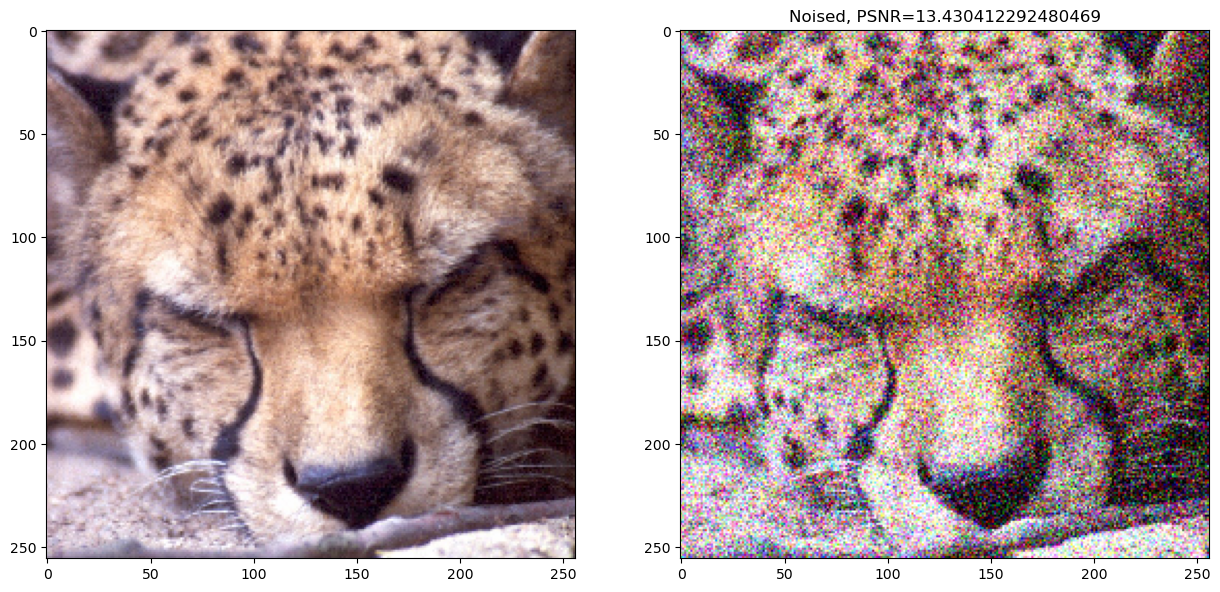

In [5]:
#!g1.1
n=5
max_value=1.
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image.array_to_img(images_clear[n]))
plt.subplot(1,2,2)
plt.title(f'Noised, PSNR={tf.image.psnr(images_clear[n], images_noised[n], max_val=max_value)}')
plt.imshow(image.array_to_img(images_noised[n]))
#image.save_img('t.jpg', image.array_to_img(images_noised[n]))
#image.save_img('tc.jpg', image.array_to_img(images_clear[n]))

In [ ]:
#!g1.1
#model = tf.keras.models.load_model('/kaggle/working/ae_v2_adamax_gelu_100_0.0054')
#model.summary()

In [6]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

In [7]:
def psnr_loss(y_true, y_pred):
    return 1/tf.image.psnr(y_true, y_pred, max_val=255)

def ssim_loss(y_true, y_pred):
    return 1/tf.image.ssim(y_true, y_pred, max_val=1)

def ssim_l2(y_true, y_pred):
    ssim = 1. - tf.math.log(tf.image.ssim(y_true, y_pred, max_val=1.))
    l2 = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return ssim + l2

def wloss(y_true, y_pred):
    return K.mean(y_true*y_pred)

combine_loss = ['mae', ssim_loss]

In [8]:
#!g1.1
def plot_result(image_clear, image_noised, image_reconstructed, max_value=255):
    plt.subplots(1,3, figsize=(15, 15))
    plt.subplot(1,3,1)
    plt.imshow(image_clear)
    #plt.imshow(image.array_to_img(image_clear))
    #plt.imshow(image_clear)
    plt.title(f'Ground True')
    plt.subplot(1,3,2)
    plt.imshow(image_noised)
    plt.title(f'Noised, PSNR={tf.image.psnr(image_clear, image_noised, max_val=max_value)}')
    plt.subplot(1,3,3)
    plt.imshow(image_reconstructed)
    plt.title(f'Reconstructed, PSNR={tf.image.psnr(image_clear, image_reconstructed, max_val=max_value)}')

In [9]:
def calc_mean_image_metrics(images_clear, images_reconstructed, max_value):
    psnrs = []
    ssims = []
    for i in range(images_reconstructed.shape[0]):
        psnr = tf.image.psnr(images_clear[i], images_reconstructed[i], max_val=max_value)
        psnrs.append(psnr)
        ssim = tf.image.ssim(images_clear[i], images_reconstructed[i], max_val=max_value)
        ssims.append(ssim)
    return np.mean(np.array(psnrs)), np.mean(np.array(ssims))

In [10]:
def predict_all(model, x):
    yy = []
    for i in range(x.shape[0]):
        image = x[i][np.newaxis, :]
        y = model.predict(image)
        yy.append(y[0])
    return np.array(yy)

# Autoencoder

In [32]:
#!g1.1
img_shape=(256, 256, 3)

input = Input(img_shape)
encode = Conv2D(256, kernel_size=(3,3), padding='same')(input)
encode = BatchNormalization()(encode)
encode = Activation('gelu')(encode)
encode = MaxPooling2D(pool_size=(2,2))(encode)
encode = Conv2D(256, kernel_size=(3,3), padding='same')(encode)
encode = BatchNormalization()(encode)
encode = Activation('gelu')(encode)
encode = MaxPooling2D(pool_size=(2,2))(encode)

decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(encode)
decode = BatchNormalization()(decode)
decode = Activation('gelu')(decode)
decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(decode)
decode = BatchNormalization()(decode)
decode = Activation('gelu')(decode)

out = Conv2DTranspose(3, kernel_size=(3,3), activation='sigmoid', padding='same')(decode)

ae = Model(input, out)

ae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 256)     7168      
                                                                 
 batch_normalization_15 (Bat  (None, 256, 256, 256)    1024      
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 256, 256, 256)     0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 256)    0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 256)     5900

Epoch 1/30
1600/1600 [==============================] - 154s 92ms/step - loss: 1.7592 - val_loss: 1.5770 - lr: 0.0100
Epoch 2/30
1600/1600 [==============================] - 141s 88ms/step - loss: 1.5870 - val_loss: 1.5334 - lr: 0.0100
Epoch 3/30
1600/1600 [==============================] - 142s 89ms/step - loss: 1.5380 - val_loss: 1.4993 - lr: 0.0100
Epoch 4/30
1600/1600 [==============================] - 145s 91ms/step - loss: 1.5048 - val_loss: 1.4545 - lr: 0.0100
Epoch 5/30
1600/1600 [==============================] - 147s 92ms/step - loss: 1.4777 - val_loss: 1.4912 - lr: 0.0100
Epoch 6/30
1600/1600 [==============================] - 148s 92ms/step - loss: 1.4615 - val_loss: 1.4719 - lr: 0.0100
Epoch 7/30
1600/1600 [==============================] - 148s 92ms/step - loss: 1.4467 - val_loss: 1.4242 - lr: 0.0100
Epoch 8/30
1600/1600 [==============================] - 146s 92ms/step - loss: 1.4375 - val_loss: 1.4446 - lr: 0.0100
Epoch 9/30
1600/1600 [==============================] - 

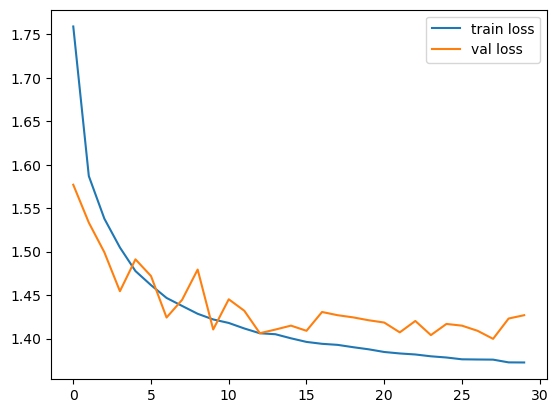

In [33]:
#!g1.1
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

ae.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = ae.fit(images_noised, images_clear,
                epochs=30,
                #initial_epoch=76,
                callbacks=[reduce_lr],
                validation_split=0.2,
                batch_size=1)

plot_history(history)

In [34]:
y = predict_all(ae, images_noised)

1/1 [==============================] - 0s 47ms/step


mean PSNR=22.35626220703125
mean SSIM=0.6677693128585815


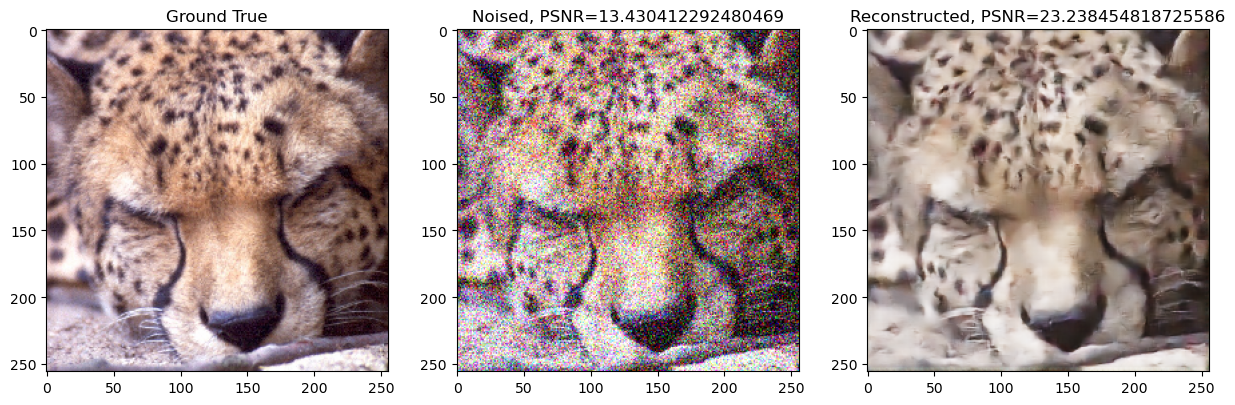

In [35]:
#!g1.1
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

In [43]:
ae_v3.save('ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best')

INFO:tensorflow:Assets written to: ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best\assets


INFO:tensorflow:Assets written to: ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best\assets


In [ ]:
ae_v2.optimizer.variables()

# dnCNN

In [9]:
img_shape=(256, 256, 3)
input = Input(img_shape)
hidden = 16
x = Conv2D(128, kernel_size=(3,3), padding='same')(input)
x = Activation('gelu')(x)
for i in range(hidden):
    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('gelu')(x)
x = Conv2D(3, kernel_size=(3,3), padding='same')(x)
out = Subtract()([input, x])

dncnn = Model(input, out)
dncnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 activation (Activation)        (None, 256, 256, 12  0           ['conv2d[0][0]']                 
                                8)                                                            

In [9]:
def dncnn_res(img_shape):

    input = Input(img_shape)
    hidden = 16
    x = Conv2D(128, kernel_size=(3,3), padding='same')(input)
    x = Activation('gelu')(x)
    for i in range(hidden):
        xx = Conv2D(128, kernel_size=(3,3), padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = Activation('gelu')(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3), padding='same')(x)
    out = Subtract()([input, x])

    model = Model(input, out)
    model.summary()
    return model
#dncnn = dncnn_res((256,256,3))

In [11]:
dncnn = dncnn_res((256,256,3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

dncnn.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = dncnn.fit(images_noised, images_clear,
                epochs=30,
                #initial_epoch=76,
                callbacks=[reduce_lr],
                validation_split=0.2,
                shuffle=True,
                batch_size=1)

plot_history(history)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 256, 256, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 activation_17 (Activation)     (None, 256, 256, 12  0           ['conv2d_18[0][0]']              
                                8)                                                          

KeyboardInterrupt: 

In [11]:
y = predict_all(dncnn, images_noised)

1/1 [==============================] - 0s 180ms/step


mean PSNR=21.895164489746094
mean SSIM=0.6157948970794678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


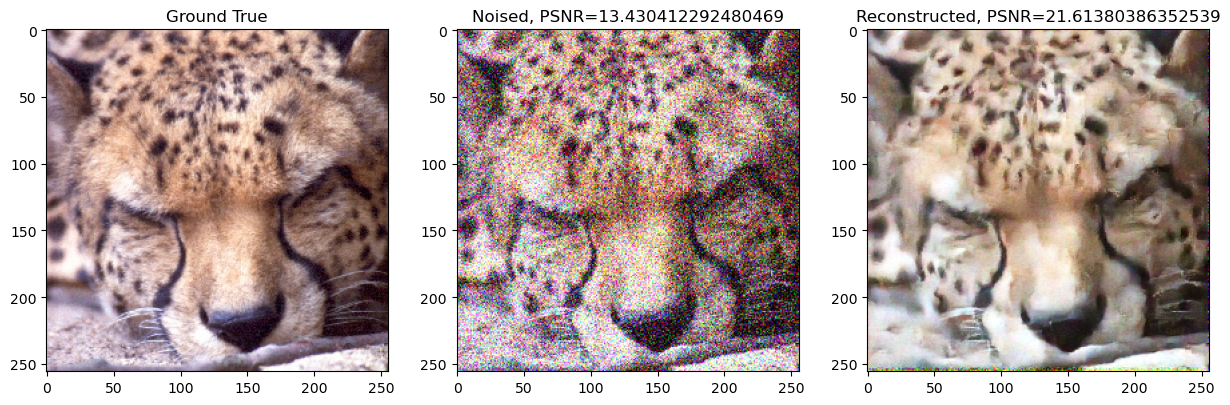

In [12]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

# RAW

In [52]:
!pip install rawpy
!pip install imageio

     -------------------------------------- 793.6/793.6 kB 6.3 MB/s eta 0:00:00


In [70]:
import rawpy
import scipy as sp
import statsmodels


In [75]:
raw = rawpy.imread('raw_noise/high_iso/test_0001.CR3')

(4498, 6742, 3)


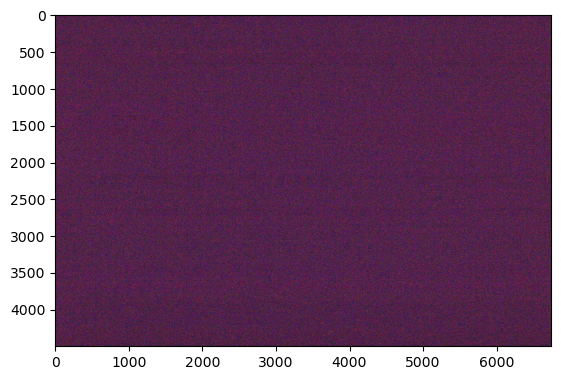

In [76]:
rgb = raw.postprocess(use_camera_wb=True, output_color=rawpy.ColorSpace.sRGB)
print (rgb.shape)
plt.imshow(rgb)

In [77]:
vec=rgb.flatten()

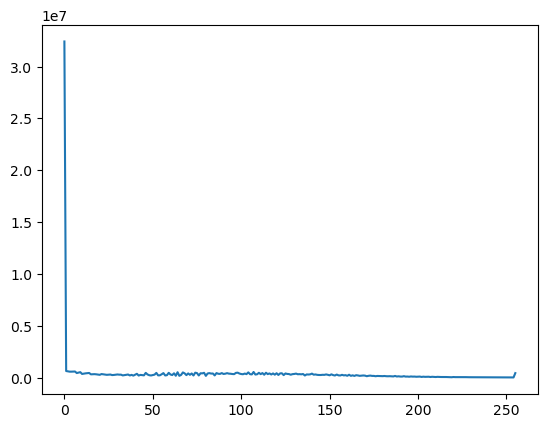

In [79]:
vec_counts = np.unique(vec, return_counts=True)
plt.plot(vec_counts[0], vec_counts[1])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f488d26a30>,
 'caps': [<matplotlib.lines.Line2D at 0x1f488d26fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f488d26760>],
 'medians': [<matplotlib.lines.Line2D at 0x1f488d4e5b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f488d4e880>],
 'means': []}

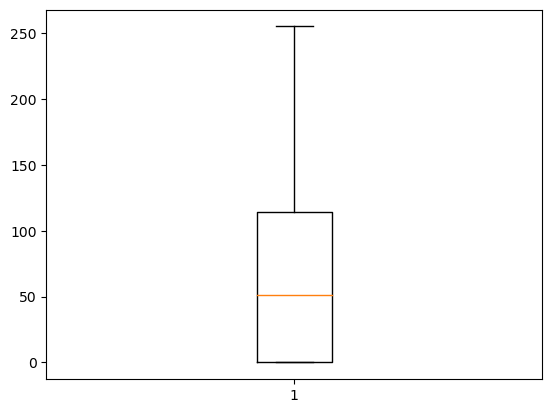

In [73]:
plt.boxplot(vec)

In [80]:
from scipy.stats.sampling import DiscreteGuideTable

In [84]:
vec

array([  0,  99,   0, ...,   0, 106,   0], dtype=uint8)

1.0000000000000004


(array([4540.,  777.,  970., 1016.,  939.,  753.,  461.,  287.,  134.,
         123.]),
 array([  0. ,  24.4,  48.8,  73.2,  97.6, 122. , 146.4, 170.8, 195.2,
        219.6, 244. ]),
 <BarContainer object of 10 artists>)

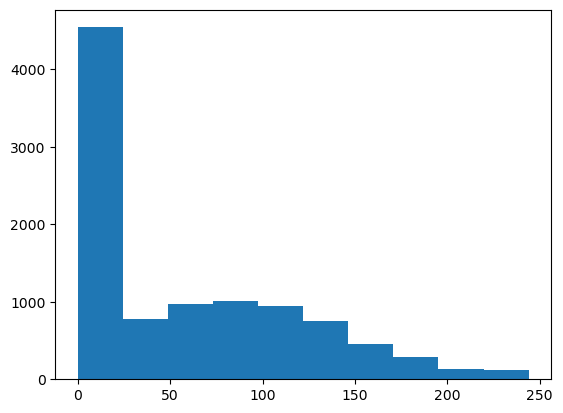

In [85]:
vec_p = vec_counts[1]/len(vec)
print (sum(vec_p))
rng = DiscreteGuideTable(vec_p)

xx = []
for i in range(10000):
    xx.append(rng.rvs())
    
plt.hist(xx)

In [183]:
def noise():
    x = rng.rvs()
    print (x)
    yield x
    
    
x = np.fromiter(noise()) #, dtype=(int, (1,10)))
x

TypeError: fromiter() missing required argument 'dtype' (pos 2)

In [181]:
def cut_image(image):
    subimages = []
    
    
    return subimages

# Unet

In [12]:
def model_unet(img_shape):
    
    input = Input(img_shape)

    conv1_1 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(input)
    conv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(conv1_1)
    conv1_p = MaxPooling2D(2,2)(conv1_2)
    conv1_bn = BatchNormalization()(conv1_p)

    conv2_1 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv1_bn)
    conv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv2_1)
    conv2_p = MaxPooling2D(2,2)(conv2_2)
    conv2_bn = BatchNormalization()(conv2_p)

    conv3_1 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv2_bn)
    conv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv3_1)
    conv3_p = MaxPooling2D(2,2)(conv3_2)
    conv3_bn = BatchNormalization()(conv3_p)

    conv4_1 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv3_bn)
    conv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv4_1)
    conv4_p = MaxPooling2D(2,2)(conv4_2)
    conv4_bn = BatchNormalization()(conv4_p)

    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv4_bn)
    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv_btnk)

    upconv4_1 = Conv2DTranspose(512, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(conv_btnk)
    upconv4_concat = Add()([upconv4_1, conv4_2])
    upconv4_bn = BatchNormalization()(upconv4_concat)
    upconv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_bn)
    upconv4_3 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_2)

    upconv3_1 = Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv4_3)
    upconv3_concat = Add()([upconv3_1, conv3_2])
    upconv3_bn = BatchNormalization()(upconv3_concat)
    upconv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_bn)
    upconv3_3 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_2)

    upconv2_1 = Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv3_3)
    upconv2_concat = Add()([upconv2_1, conv2_2])
    upconv2_bn = BatchNormalization()(upconv2_concat)
    upconv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_bn)
    upconv2_3 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_2)

    upconv1_1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv2_3)
    upconv1_concat = Add()([upconv1_1, conv1_2])
    upconv1_bn = BatchNormalization()(upconv1_concat)
    upconv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_bn)
    upconv1_3 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_2)

    conv_out = Conv2D(3, kernel_size=(1,1), activation='relu', padding='same')(upconv1_3)
    #out = Add()([input, conv_out])
    out = conv_out

    model = Model(input, out)
    model.summary()
    
    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 256, 256, 64  832         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_37 (Conv2D)             (None, 256, 256, 64  16448       ['conv2d_36[0][0]']              
                                )                                                           

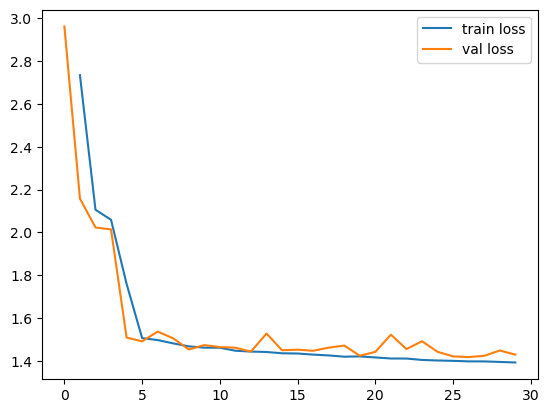

In [13]:
unet = model_unet((256, 256, 3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

unet.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = unet.fit(images_noised, images_clear,
                epochs=30,
                callbacks=[reduce_lr],
                validation_split=0.2,
                #huffle=True,
                batch_size=1)

plot_history(history)

In [14]:
y = predict_all(unet, images_noised)

1/1 [==============================] - 0s 53ms/step


mean PSNR=21.322179794311523
mean SSIM=0.6651113629341125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


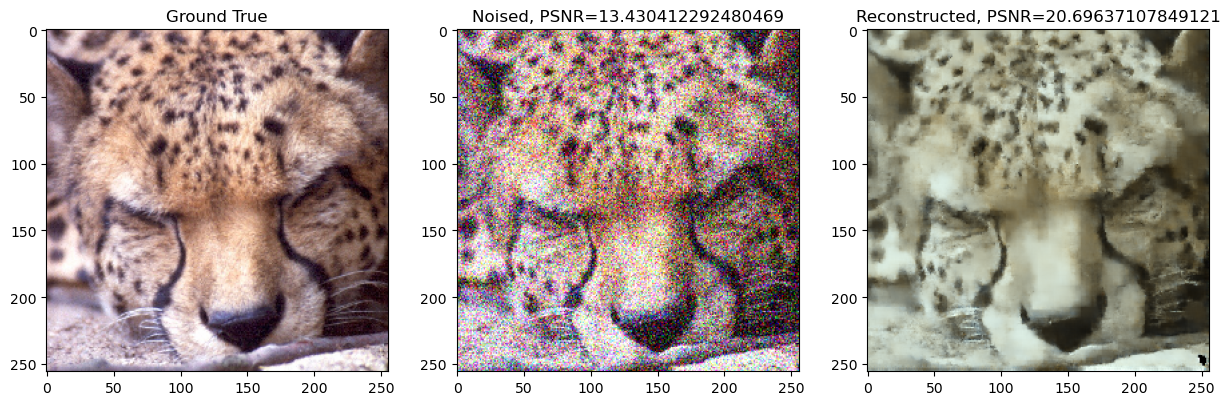

In [15]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

# GAN

In [36]:
def dncnn_res_gan(img_shape):

    input = Input(img_shape)
    hidden = 6
    x = Conv2D(256, kernel_size=(3,3), padding='same')(input)
    x = LeakyReLU(0.2)(x)
    for i in range(hidden):
        xx = Conv2D(256, kernel_size=(3,3), padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = LeakyReLU(0.2)(xx)
        xx = Conv2D(256, kernel_size=(3,3), padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = LeakyReLU(0.2)(xx)        
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')(x)
    #out = Subtract()([input, x])
    out = x

    model = Model(input, out)
    model.summary()
    return model

In [37]:
def model_unet_gan(img_shape):
    
    input = Input(img_shape)

    conv1_1 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(input)
    conv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(conv1_1)
    conv1_p = MaxPooling2D(2,2)(conv1_2)
    conv1_bn = BatchNormalization()(conv1_p)

    conv2_1 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv1_bn)
    conv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv2_1)
    conv2_p = MaxPooling2D(2,2)(conv2_2)
    conv2_bn = BatchNormalization()(conv2_p)

    conv3_1 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv2_bn)
    conv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv3_1)
    conv3_p = MaxPooling2D(2,2)(conv3_2)
    conv3_bn = BatchNormalization()(conv3_p)

    conv4_1 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv3_bn)
    conv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv4_1)
    conv4_p = MaxPooling2D(2,2)(conv4_2)
    conv4_bn = BatchNormalization()(conv4_p)

    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv4_bn)
    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv_btnk)

    upconv4_1 = Conv2DTranspose(512, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(conv_btnk)
    upconv4_concat = Add()([upconv4_1, conv4_2])
    upconv4_bn = BatchNormalization()(upconv4_concat)
    upconv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_bn)
    upconv4_3 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_2)

    upconv3_1 = Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv4_3)
    upconv3_concat = Add()([upconv3_1, conv3_2])
    upconv3_bn = BatchNormalization()(upconv3_concat)
    upconv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_bn)
    upconv3_3 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_2)

    upconv2_1 = Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv3_3)
    upconv2_concat = Add()([upconv2_1, conv2_2])
    upconv2_bn = BatchNormalization()(upconv2_concat)
    upconv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_bn)
    upconv2_3 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_2)

    upconv1_1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv2_3)
    upconv1_concat = Add()([upconv1_1, conv1_2])
    upconv1_bn = BatchNormalization()(upconv1_concat)
    upconv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_bn)
    upconv1_3 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_2)

    conv_out = Conv2D(3, kernel_size=(1,1), activation='relu', padding='same')(upconv1_3)
    #out = Add()([input, conv_out])
    out = conv_out

    model = Model(input, out)
    model.summary()
    
    return model

In [11]:
def ae_gan(img_shape):
    
    input = Input(img_shape)
    encode = Conv2D(256, kernel_size=(3,3), padding='same')(input)
    encode = BatchNormalization()(encode)
    encode = Activation('gelu')(encode)
    encode = MaxPooling2D(pool_size=(2,2))(encode)
    encode = Conv2D(256, kernel_size=(3,3), padding='same')(encode)
    encode = BatchNormalization()(encode)
    encode = Activation('gelu')(encode)
    encode = MaxPooling2D(pool_size=(2,2))(encode)

    decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(encode)
    decode = BatchNormalization()(decode)
    decode = Activation('gelu')(decode)
    decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(decode)
    decode = BatchNormalization()(decode)
    decode = Activation('gelu')(decode)

    out = Conv2DTranspose(3, kernel_size=(3,3), activation='sigmoid', padding='same')(decode)

    ae = Model(input, out)

    ae.summary()
    
    return ae

In [12]:
def generator():
    model = ae_gan((256,256,3))
    #model = dncnn_res_gan((256,256,3))  
    #model = model_unet_gan((256,256,3))
    #model = dncnn_res_gan_v2((256,256,3))
    return model

In [16]:
def discriminator():
    
    img_shape = (256, 256, 3)
    
    input = Input(img_shape)
    x = Conv2D(64, kernel_size=(3,3), padding='same')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D()(x)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    model.summary()
    
    return model

In [17]:
class denoiser_gan(Model):
    
    img_shape = (256, 256, 3)
    
    def __init__(self, generator, discriminator):
        super (denoiser_gan, self).__init__()
        self.G = generator
        self.D = discriminator
        
    def compile (self, g_optimizer, d_optimizer, loss):
        super(denoiser_gan, self).compile()
        self.G.optimizer = g_optimizer
        self.D.optimizer = d_optimizer
        self.G.loss = loss
        self.D.loss = loss
        self.loss = loss
        
        
    
    def train_step(self, data):        
        images_noised, images_clear = data

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:

            images_reconstructed = self.G(images_noised, training=True)

            real_out = self.D(images_clear  + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)), training=True)
            #fake_out = self.D(images_reconstructed, training=True)
            fake_out = self.D(images_reconstructed + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)), training=True)

            d_real_loss = self.loss(tf.ones_like(real_out), real_out)
            d_fake_loss = self.loss(tf.zeros_like(fake_out), fake_out)
            d_loss = d_real_loss + d_fake_loss
                        
            g_loss_adv = self.loss(tf.ones_like(fake_out), fake_out)
            #g_loss_content = tf.losses.MeanAbsoluteError()(images_clear, images_reconstructed)
            #g_loss_content = ssim_l2(images_clear, images_reconstructed)
            g_loss = g_loss_adv #+ g_loss_content
            
            
        g_grads = g_tape.gradient(g_loss, self.G.trainable_variables)
        d_grads = d_tape.gradient(d_loss, self.D.trainable_variables)
        
        self.G.optimizer.apply_gradients(zip(g_grads, self.G.trainable_variables))
        self.D.optimizer.apply_gradients(zip(d_grads, self.D.trainable_variables))
        
        ssim = tf.image.ssim(images_clear, images_reconstructed, max_val=1.)
        
        return {"d_r": d_real_loss, "d_f" :d_fake_loss, "g_loss": g_loss, "ssim" : ssim}
        #return {"d": d_loss, "g_adv" :g_loss_adv, "g_cont": g_loss_content, "g_loss": g_loss, "ssim" : ssim}
            
    def call(self, inputs):
        return self.G(inputs)
    
    def predict(self, inputs):
        return self.G.predict(inputs)
    
    #############################   tf.print()

In [18]:
batch_size = 1
G = generator()
D = discriminator()
dngan = denoiser_gan(G, D)
g_opt = Adam(learning_rate=2e-4, beta_1=0.5)
d_opt = Adam(learning_rate=1e-4, beta_1=0.5)
loss = tf.keras.losses.BinaryCrossentropy()

#D.compile(d_opt, loss)
#G.compile(g_opt, loss)
#dngan.compile(Adam(learning_rate=2e-4, beta_1=0.5), loss)
dngan.compile(g_opt, d_opt, loss)
history = dngan.fit(images_noised[:100], images_clear[:100],
                    epochs=2000,
                    batch_size=1
                   )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 256)     7168      
                                                                 
 batch_normalization_4 (Batc  (None, 256, 256, 256)    1024      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 256, 256, 256)     0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 256)    0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 256)     5900

100/100 [==============================] - 17s 168ms/step - d_r: 0.4490 - d_f: 0.4862 - g_loss: 3.8504 - ssim: 0.1845
Epoch 12/2000
100/100 [==============================] - 17s 166ms/step - d_r: 0.4143 - d_f: 0.3864 - g_loss: 4.8128 - ssim: 0.1048
Epoch 13/2000
100/100 [==============================] - 17s 167ms/step - d_r: 0.2907 - d_f: 0.1959 - g_loss: 3.9473 - ssim: 0.0601
Epoch 14/2000
100/100 [==============================] - 17s 169ms/step - d_r: 0.1994 - d_f: 0.3228 - g_loss: 5.0124 - ssim: 0.0567
Epoch 15/2000
100/100 [==============================] - 17s 166ms/step - d_r: 0.3897 - d_f: 0.3756 - g_loss: 6.1260 - ssim: 0.0210
Epoch 16/2000
100/100 [==============================] - 17s 167ms/step - d_r: 0.2941 - d_f: 0.2481 - g_loss: 6.2975 - ssim: 0.0732
Epoch 17/2000
100/100 [==============================] - 19s 192ms/step - d_r: 0.5078 - d_f: 0.6367 - g_loss: 5.4503 - ssim: 0.1615
Epoch 18/2000
100/100 [==============================] - 21s 207ms/step - d_r: 0.7840 - d_

100/100 [==============================] - 17s 166ms/step - d_r: 0.2072 - d_f: 0.2290 - g_loss: 4.1005 - ssim: 0.3408
Epoch 74/2000
100/100 [==============================] - 17s 169ms/step - d_r: 0.1149 - d_f: 0.1141 - g_loss: 4.5453 - ssim: 0.3393
Epoch 75/2000
100/100 [==============================] - 17s 173ms/step - d_r: 0.1975 - d_f: 0.2924 - g_loss: 5.0687 - ssim: 0.3390
Epoch 76/2000
100/100 [==============================] - 17s 168ms/step - d_r: 0.3335 - d_f: 0.3598 - g_loss: 3.3956 - ssim: 0.3405
Epoch 77/2000
100/100 [==============================] - 17s 173ms/step - d_r: 0.3417 - d_f: 0.3119 - g_loss: 3.4796 - ssim: 0.3300
Epoch 78/2000
100/100 [==============================] - 17s 168ms/step - d_r: 0.2582 - d_f: 0.2201 - g_loss: 4.3335 - ssim: 0.3332
Epoch 79/2000
100/100 [==============================] - 17s 170ms/step - d_r: 0.1503 - d_f: 0.1857 - g_loss: 5.2996 - ssim: 0.3319
Epoch 80/2000
100/100 [==============================] - 17s 173ms/step - d_r: 0.2586 - d_

100/100 [==============================] - 17s 174ms/step - d_r: 0.1012 - d_f: 0.0946 - g_loss: 6.4699 - ssim: 0.3682
Epoch 135/2000
100/100 [==============================] - 18s 177ms/step - d_r: 0.2975 - d_f: 0.2281 - g_loss: 3.5484 - ssim: 0.3915
Epoch 136/2000
100/100 [==============================] - 16s 163ms/step - d_r: 0.2138 - d_f: 0.2843 - g_loss: 3.4848 - ssim: 0.3748
Epoch 137/2000
100/100 [==============================] - 17s 166ms/step - d_r: 0.1555 - d_f: 0.1569 - g_loss: 3.9318 - ssim: 0.3753
Epoch 138/2000
100/100 [==============================] - 17s 166ms/step - d_r: 0.1654 - d_f: 0.1690 - g_loss: 4.2524 - ssim: 0.3806
Epoch 139/2000
100/100 [==============================] - 17s 170ms/step - d_r: 0.3150 - d_f: 0.3885 - g_loss: 4.2149 - ssim: 0.3670
Epoch 140/2000
100/100 [==============================] - 17s 174ms/step - d_r: 0.2014 - d_f: 0.2326 - g_loss: 3.1367 - ssim: 0.3804
Epoch 141/2000
100/100 [==============================] - 17s 166ms/step - d_r: 0.12

100/100 [==============================] - 1754s 18s/step - d_r: 0.2257 - d_f: 0.1927 - g_loss: 3.8114 - ssim: 0.3932
Epoch 196/2000
100/100 [==============================] - 2019s 20s/step - d_r: 0.2203 - d_f: 0.1864 - g_loss: 3.9226 - ssim: 0.3992
Epoch 197/2000
 18/100 [====>.........................] - ETA: 31:32 - d_r: 0.4075 - d_f: 0.3556 - g_loss: 4.2336 - ssim: 0.4355

KeyboardInterrupt: 

In [ ]:
print(dngan.optimizer)
print(dngan.G.optimizer)
print(dngan.D.optimizer)
print(dngan.loss)
print(dngan.G.loss)
print(dngan.D.loss)

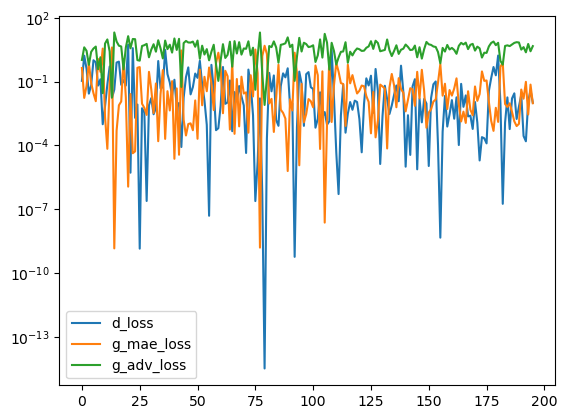

In [20]:
history = dngan.history
plt.plot(history.history['d_r'], label='d_loss')
plt.plot(history.history['d_f'], label='g_mae_loss')
plt.plot(history.history['g_loss'], label='g_adv_loss')
plt.yscale('log')
plt.legend()
plt.show()

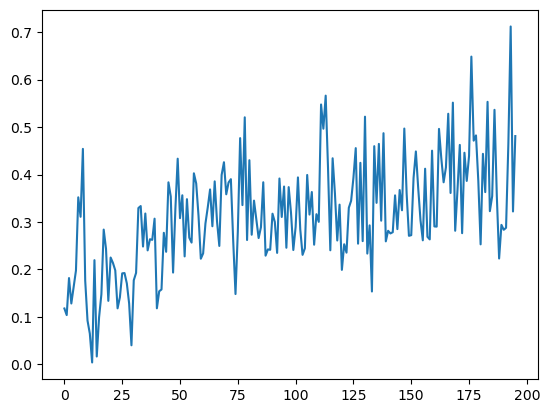

In [21]:
history = dngan.history
plt.plot(history.history['ssim'], label='ssim')

In [ ]:
y = predict_all(dngan, images_noised[:20])

mean PSNR=20.89706802368164
mean SSIM=0.5380624532699585


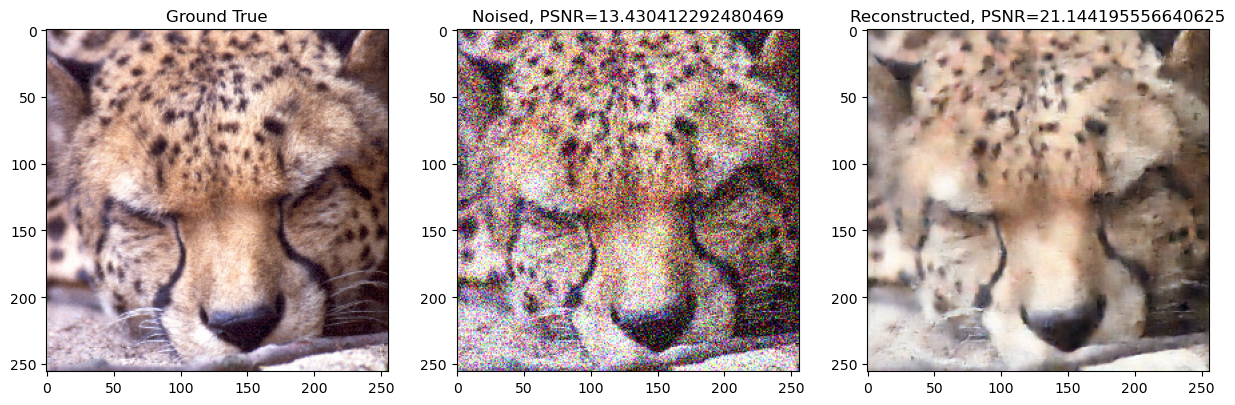

In [18]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

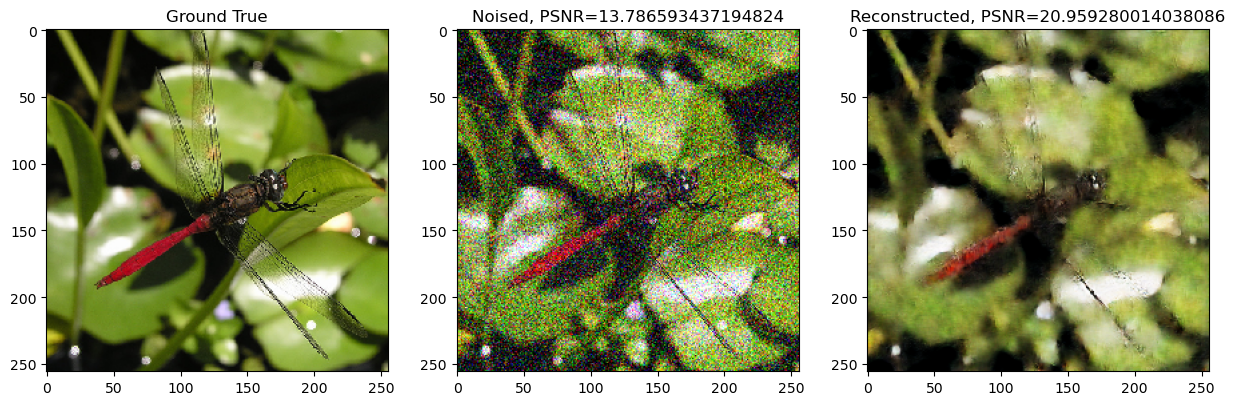

In [26]:
n=157
plot_result(images_clear[n],
           images_noised[n],
           y[n],
           max_value=1.)

In [ ]:
#G.save('gan/G')
#D.save('gan/D')
#dngan.fit(images_noised[:100], images_clear[:100], epochs=1)
dngan.save('gan/dngan')
#dngan.save_weights('gan/dngan_weights')